In [1]:
from binance.client import Client
from binance import ThreadedWebsocketManager
import binance as bn
import pandas as pd
import sys
from datetime import datetime, timedelta
import ta as ta
import numpy as np
import json
import sys
sys.path.append('/Users/jp/Desktop/Investment/utils')
import utils
import matplotlib.pyplot as plt
import smtplib
import time
import json

In [8]:
class Futures_trader():
    """
    Class to perform live testing using Binance Futures testnet stream of data
    """ 
    def __init__(self, symbol=None, units='0.0006', interval=None, ema_slow=None, ema_fast=None, ema_signal=None, sma_slow=None, sma_fast=None, sl=None, tp=None, leverage=2, bot_name='macd_sma', testnet=None, assigned_duration_minutes=None, assigned_emergency_price_chg_pu=None):
        """
        :param symbol: ticker in Binance, i.e. "BTCUSDT"
        :type symbol: str.
        ----
        :param units: amount of base units, i.e. "BTC"
        :param type: float.
        ----
        :param interval: a string among the followings: ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        :type interval: str.
        ----
        :param ema_slow: EMA slow for MACD calculation
        :type ema_slow: int.
        ----
        :param ema_fast: EMA fast for MACD calculation
        :type ema_fast: int.
        ----
        :param ema_signal: EMA signal for MACD calculation
        :type ema_signal: int.
        ----
        :param sma_slow: SMA slow signal for sma cross calculation
        :type sma_slow: int.
        ----        
        :param sma_fast: SMA fast signal for sma cross calculation
        :type sma_fast: int.
        ----            
        :param sl: per unit of closing price to execute stop loss
        :type sl: float
        ----
        :param tp: per unit of closing price to execute take profit
        :type tp: float
        ----
        :param leverage: leverage to use
        :type leverage: integer
        ----
        :param bot_name: name of the current strategy
        :type bot_name: string
        ---
        :param testnet: if True, testnet is used, otherwise REAL Binance account
        :type testnet: bool.
        ----
        :param assigned_duration_minutes: amount of minutes that the sesion is expected to last, if no problems appear.
        :type assigned_duration_minutes: int.
        ----
        :param: assigned_emergency_price_chg_pu: per unit threshold (in absolute value) above which a sell order will be executed for safety purposes.
        In the case of a price increase the pct is taken as double of the value introduced (ratio 2 win : 1 lose)
        :type assigned_emergency_price_chg_pu: float
        """
        self.units = units
        self.symbol = symbol
        self.interval = interval
        self.ema_slow = ema_slow
        self.ema_fast = ema_fast
        self.ema_signal = ema_signal 
        self.sma_slow = sma_slow
        self.sma_fast = sma_fast
        self.sl = sl
        self.tp = tp
        self.leverage = leverage
        self.bot_name = bot_name
        self.testnet = testnet 
        self.assigned_duration_minutes = assigned_duration_minutes
        self.assigned_emergency_price_chg_pu = assigned_emergency_price_chg_pu
        self.run_end_time_utc = None #time in UTC when the calculation finished
        self.run_end_delta = None #amount of time that has passed since the beginning of the calculation
        self.data = pd.DataFrame() #initialized dataframe to contain all OHLC data
        self.orders = 0 #counter of the number of orders
        self.position = None #initially no position is decided, it is pending to analysis recent data of macd to decide if it is long (1), neutral (0) or no position ('np')
        self.client = None #Binance client
        self.trade_start_time_utc = None # time in utc to be defined when the stream of OHLC starts ( this time
        self.twm = None # Initialize ws client
        self.cum_profits = 0 #accumulated profits in the trading sesion
        self.close_pair = [] #two consecutive "close" prices to implement the safety returns threshold
        self.emergency_price_chg_flag = False #flag to activate the signal
        self.emergency_msg = None #message to be sent when emergency price signal activated
        self.pu_price_chg = None #percetatge of change in price monitored every second
        self.conn = None #smtp connection
        self.login_mail() #initialize smtp google account
        self.increase_counter = 0 #counter to monitor consecutive sharp increases in price per second
        self.decrease_counter = 0 #counter to monitor consecutive sharp decreases in price per second
        self.bot_name = "" #bot name to be defined in each child class
        self.kline_tlast = None #date of latest kandle complete to use in define_strategy()
        self.kline_tlast = None #date of latest kandle being reported but most likely incomplete
        
    def start_trading(self):
        #self.client.futures_change_margin_type(symbol = "BTCUSDT", marginType = "CROSSED")    def start_trading(self):
        self.trade_start_time_utc = datetime.utcnow()
        self.prepare_recent_data()
        self.client.futures_change_leverage(symbol = "BTCUSDT", leverage = self.leverage)        
        self.init_socket()
        
    def init_socket(self):
        self.twm = ThreadedWebsocketManager()
        self.twm.start() 
        
        try:                  
            self.twm.start_kline_futures_socket(callback = self.stream_candles, symbol = self.symbol, interval = self.interval)
        except (BinanceAPIException, ConnectionResetError, requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:
            print(e)
            print('Something went wrong. Error occured at %s. The sesions will be automatically stopped after GOING NEUTRAL.' % (datetime.now().astimezone(timezone.utc)))
            self.stop_ses()

    def stream_candles(self, msg):
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        self.kline_tlast = start_time
        print(start_time)
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
    
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time, 'Open'] = first
        self.data.loc[start_time, 'High'] = high
        self.data.loc[start_time, 'Low'] = low
        self.data.loc[start_time, 'Close'] = close
        self.data.loc[start_time, 'Volume'] = volume
        self.data.loc[start_time, 'Complete'] = complete
        #update MACD parameters with each ws retrieval
        macd_diff = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_signal()         
        #assigning the macd values to ticker dataframe
        self.data.loc[start_time, 'macd_diff'] = macd_diff.iloc[-1]
        self.data.loc[start_time, 'macd_macd'] = macd_macd.iloc[-1]
        self.data.loc[start_time, 'macd_signal'] = macd_signal.iloc[-1]
        #update SMAs with each ws retrieval
        sma_fast_ps = ta.trend.SMAIndicator(close=self.data.Close, window=self.sma_fast, fillna=False).sma_indicator()
        sma_slow_ps = ta.trend.SMAIndicator(close=self.data.Close, window=self.sma_slow, fillna=False).sma_indicator()
        #assigning the smas values to ticker dataframe
        self.data.loc[start_time, 'sma_fast_ps'] = sma_fast_ps.iloc[-1]
        self.data.loc[start_time, 'sma_slow_ps'] = sma_slow_ps.iloc[-1]
                
        print(".", end = "", flush = True) # just print something to get a feedback (everything OK)
        dt = datetime.utcnow() - self.trade_start_time_utc
        
        if ((dt) > timedelta(minutes=self.assigned_duration_minutes)):
            self.stop_ses()
            
        if (len(self.close_pair) == 0):
            self.close_pair.append(close)
        if (len(self.close_pair) == 1):
            self.close_pair.insert(0,close)
        if (len(self.close_pair) == 2):
            self.close_pair.pop()
            self.close_pair.insert(0,close)
            self.pu_price_chg = ((self.close_pair[1]/self.close_pair[0])-1)
            
            # condition for emergency price increase
            if (self.pu_price_chg > 2*self.assigned_emergency_price_chg_pu):
                self.emergency_price_chg_flag = True
                self.decrease_counter = 0
                self.increase_counter += 1
                self.emergency_msg = f"PRICE CHANGE - INCREASE - {self.increase_counter}"
                print(self.emergency_msg)
                
                if (self.increase_counter < 3):
                    pass
                elif (self.increase_counter == 3):
                    self.emergency_position_eval_increase()                               
                    self.emergency_price_chg_flag = False
                    self.increase_counter = 0
                    self.end_socket()
                    time.sleep(45)
                    self.init_socket()
                else:
                    pass
            # condition for emergency price decrease                    
            elif (self.pu_price_chg < -1*self.assigned_emergency_price_chg_pu):
                self.emergency_price_chg_flag = True
                self.increase_counter = 0
                self.decrease_counter += 1
                self.emergency_msg = f"PRICE CHANGE - DECREASE - {self.decrease_counter}"
                print(self.emergency_msg)                
            
                if (self.decrease_counter < 3):
                    pass
                elif (self.decrease_counter == 3):
                    self.emergency_position_eval_decrease()
                    self.emergency_price_chg_flag = False
                    self.decrease_counter = 0
                    self.end_socket()
                    time.sleep(45)
                    self.init_socket()
                else:
                    pass
            # condition for no emergency price change        
            else:
                self.emergency_price_chg_flag = False
                self.increase_counter = 0
                self.decrease_counter = 0
        
        # Every second that the execution arrives here, it means one of these two things:
        # 1) there has been no emergency price change
        # 2) there has been an emergency price change but it has been procesed
        if (complete == True):
            if (self.emergency_price_chg_flag==False): #continue the normal process if no emergency has been detected or if the flag has been set to false after processing an emergency
                self.update_position()
                self.execute_trades()
            else: #if we enter into the completed kandle but we are in the middle of a emergency price: do nothing
                  # since it means that we are in the middle of assessing an emergency price change situation 
                pass

    def prepare_recent_data(self):
        '''
        :param start: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-01-29-20:00"
        :type start: str.
        :param end: a string with the following format ""%Y-%m-%d-%H:%M" .i.e. "2022-02-29-20:00"
        :type end: str.
        '''
        #Prepare pre-data to the present moment with non NaN for the trading period (macd paramters ready)
        current_time_obj = datetime.now()
        current_time = int(current_time_obj.timestamp()*1000)
        
        #["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        extra_periods = 0
        ema_diff = self.ema_slow + self.ema_signal + 2
        
        # Necessary extra periods to have enough data to calculate the strategy parameters at the present moment
        if (ema_diff >= self.sma_slow):
            extra_periods = ema_diff * 2
        else:
            extra_periods = self.sma_slow * 2
        
        td = timedelta()
        if 'm' in self.interval:
            num_min = int(self.interval.replace('m',''))
            td = timedelta(minutes=num_min*(extra_periods))
        if 'h' in self.interval:
            num_h = int(self.interval.replace('h',''))
            td = timedelta(hours=num_h*(extra_periods))
        if 'd' in self.interval:
            num_day = int(self.interval.replace('d',''))
            td = timedelta(days=num_day*(extra_periods))
        if 'w' in self.interval:
            num_week = int(self.interval.replace('w',''))
            td = timedelta(weeks=num_week*(extra_periods))
        if 'M' in self.interval:
            num_week_m = int(self.interval.replace('M',''))
            td = timedelta(weeks=num_week_m * 4 * (extra_periods))

        from_time_obj = current_time_obj - td
        from_time = int((current_time_obj - td).timestamp()*1000)
        self.data, self.client = utils.futures_history(symbol=self.symbol, interval=self.interval, start=from_time, end=current_time, testnet=True)
        #obtaining MACD instance from python ta
        macd_diff = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_diff()
        macd_macd = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd()
        macd_signal = ta.trend.MACD(close=self.data.Close, window_slow=self.ema_slow, window_fast=self.ema_fast, window_sign=self.ema_signal, fillna=False).macd_signal()
        #assigning the values of macd to ticker dataframe
        self.data['macd_diff'] = macd_diff
        self.data['macd_macd'] = macd_macd
        self.data['macd_signal'] = macd_signal
        #calculating SMA fast and slow
        sma_fast_ps = ta.trend.SMAIndicator(close=self.data.Close, window=self.sma_fast, fillna=False).sma_indicator()
        sma_slow_ps = ta.trend.SMAIndicator(close=self.data.Close, window=self.sma_slow, fillna=False).sma_indicator()
        #assigning the smas values to ticker dataframe
        self.data['sma_fast_ps'] = sma_fast_ps
        self.data['sma_slow_ps'] = sma_slow_ps
        #initialize dataframe columns for prepared data
        self.data['position'] = 0
        self.data['macd_inv_sign'] = 0
        self.data['sma_conf'] = 0
        self.data['sma_inv_sign'] = 0
        self.data['macd_diff_conf'] = 0
        self.data['sl_flag_short'] = 'undefined'
        self.data['tp_flag_short'] = 'undefined'
        self.data['sl_flag_long'] = 'undefined'
        self.data['tp_flag_long'] = 'undefined'          
        self.stablish_initial_position()
        #last candle retrieved from old data till the present moment will be incomplete 99.9% of the time
        self.data["Complete"] = [True for row in range(len(self.data)-1)] + [False]
        #decide position to be given to the latest recent data kandle (not completed in 99% of cases and that is 
        #going to be updated by the stream of data, so actually, position given to the latest kandle at this point
        #it is mots likely not to be used, but updated.
        
    def stablish_initial_position(self):

        # --------------------- MACD CROSS SIGNAL + SMA CONFIRMATION ---------------------
        
        #macd cross short
        ht_macd_diff_pos = self.data.macd_diff.shift(1) > 0
        ht_macd_diff_plusone_neg = self.data.macd_diff < 0        
       
        #sma short confirmation
        sma_conf_short = self.data.sma_fast_ps < self.data.sma_slow_ps
        
        #stablish short positions
        self.data.loc[ht_macd_diff_pos & ht_macd_diff_plusone_neg, 'macd_inv_sign'] = -1
        self.data.loc[sma_conf_short, 'sma_conf'] = -1
        
        #macd cross long
        ht_macd_diff_neg = self.data.macd_diff.shift(1) < 0
        ht_macd_diff_plusone_pos = self.data.macd_diff > 0
        
        #sma long confirmation
        sma_conf_long = self.data.sma_fast_ps > self.data.sma_slow_ps        
        
        #stablish buy positions
        self.data.loc[ht_macd_diff_neg & ht_macd_diff_plusone_pos, 'macd_inv_sign'] = 1
        self.data.loc[sma_conf_long, 'sma_conf'] = 1
        
        # ---------------------------------------------------------------------------------
        
        # --------------------- SMA CROSS SIGNAL + MACD_DIFF CONFIRMATION -----------------
        
        #sma cross short
        ht_sma_pos = self.data.sma_fast_ps.shift(1) > self.data.sma_slow_ps.shift(1)
        ht_sma_plusone_neg = self.data.sma_fast_ps < self.data.sma_slow_ps
        
        #macd_diff short confirmation
        macd_diff_conf_short = self.data.macd_diff < 0
        
        #stablish short positions
        self.data.loc[ht_sma_pos & ht_sma_plusone_neg, 'sma_inv_sign'] = -1
        self.data.loc[macd_diff_conf_short, 'macd_diff_conf'] = -1
        
        #sma cross long
        ht_sma_neg = self.data.sma_fast_ps.shift(1) < self.data.sma_slow_ps.shift(1)
        ht_sma_plusone_pos = self.data.sma_fast_ps > self.data.sma_slow_ps        
        
        #macd_diff long confirmation
        macd_diff_conf_long = self.data.macd_diff > 0
        
        #stablish buy positions
        self.data.loc[ht_sma_neg & ht_sma_plusone_pos, 'sma_inv_sign'] = 1
        self.data.loc[macd_diff_conf_long, 'macd_diff_conf'] = 1        
        
        # ---------------------------------------------------------------------------------
        for index, data in self.data.iterrows():
            
            if ((data.macd_inv_sign == 1 and data.sma_inv_sign == 1) or (data.macd_inv_sign == 1 and data.sma_conf == 1)): #CHECKED
                
                self.data.loc[index, 'position'] = 1
                one_delta_pos = index + (self.data.index[1]-self.data.index[0])
                self.data_sub_buy = self.data.loc[one_delta_pos:]
                for index_sub_buy, data_sub_buy in self.data_sub_buy.iterrows():
                    # initialize flag in every loop
                    sltp_flag = False
                    sl_flag = data_sub_buy.Close <= (data.Close * (1 - self.sl))  # condition for stop loss in sub loop
                    tp_flag = data_sub_buy.Close > (data.Close * (1 + self.tp)) # condition for take profit in sub loop
                    sltp_flag = sl_flag or tp_flag # flag once detected sl or tp, to stop the long position loop
                    self.data.loc[index_sub_buy,'sl_flag_long'] = sl_flag
                    self.data.loc[index_sub_buy,'tp_flag_long'] = tp_flag                                        
                    if ((data.macd_inv_sign == -1 and data.sma_inv_sign == -1) or (data.macd_inv_sign == -1 and data.sma_conf == -1) or (data.sma_inv_sign == -1 and data.macd_diff_conf == -1) or sltp_flag == True):
                        if (sltp_flag == True):
                            break                    
                    else: 
                        self.data.loc[index_sub_buy, 'position'] = 1
                
            elif ((data.macd_inv_sign == -1 and data.sma_inv_sign == -1) or (data.macd_inv_sign == -1 and data.sma_conf == -1)): 
                
                self.data.loc[index, 'position'] = -1
                one_delta_pos = index + (self.data.index[1]-self.data.index[0])
                self.data_sub_sell = self.data.loc[one_delta_pos:]
                for index_sub_sell, data_sub_sell in self.data_sub_sell.iterrows():
                    # initialize flag in every loop
                    sltp_flag = False                    
                    tp_flag = data_sub_sell.Close <= (data.Close * (1 - self.tp))  # condition for stop loss in sub loop
                    sl_flag = data_sub_sell.Close > (data.Close * (1 + self.sl)) # condition for take profit in sub loop
                    sltp_flag = sl_flag or tp_flag # flag once detected sl or tp, to stop the long position loop
                    self.data.loc[index_sub_sell,'sl_flag_short'] = sl_flag
                    self.data.loc[index_sub_sell,'tp_flag_short'] = tp_flag                                          
                    if ((data.macd_inv_sign == 1 and data.sma_inv_sign == 1) or (data.macd_inv_sign == 1 and data.sma_conf == 1) or (data.sma_inv_sign == 1 and data.macd_diff_conf == 1) or sltp_flag == True):
                        if (sltp_flag == True):
                            break
                    else:
                        self.data.loc[index_sub_sell, 'position'] = -1
                        
            elif ((data.sma_inv_sign == 1 and data.macd_inv_sign == 1) or (data.sma_inv_sign == 1 and data.macd_diff_conf == 1)): #CHECKED
                
                self.data.loc[index, 'position'] = 1
                one_delta_pos = index + (self.data.index[1]-self.data.index[0])
                self.data_sub_buy = self.data.loc[one_delta_pos:]
                for index_sub_buy, data_sub_buy in self.data_sub_buy.iterrows():
                    # initialize flag in every loop
                    sltp_flag = False
                    sl_flag = data_sub_buy.Close <= (data.Close * (1 - self.sl))  # condition for stop loss in sub loop
                    tp_flag = data_sub_buy.Close > (data.Close * (1 + self.tp)) # condition for take profit in sub loop
                    sltp_flag = sl_flag or tp_flag # flag once detected sl or tp, to stop the long position loop
                    self.data.loc[index_sub_buy,'sl_flag_long'] = sl_flag
                    self.data.loc[index_sub_buy,'tp_flag_long'] = tp_flag                                            
                    if ((data.sma_inv_sign == -1 and data.macd_inv_sign == -1) or (data.sma_inv_sign == -1 and data.macd_diff_conf == -1) or (data.macd_inv_sign == -1 and data.sma_conf == -1) or sltp_flag == True):
                        if (sltp_flag == True):
                            break
                    else:
                        self.data.loc[index_sub_buy, 'position'] = 1
                
            elif ((data.sma_inv_sign == -1 and data.macd_inv_sign == -1) or (data.sma_inv_sign == -1 and data.macd_diff_conf == -1)):
                
                self.data.loc[index, 'position'] = -1
                one_delta_pos = index + (self.data.index[1]-self.data.index[0])
                self.data_sub_sell = self.data.loc[one_delta_pos:]
                for index_sub_sell, data_sub_sell in self.data_sub_sell.iterrows():
                    # initialize flag in every loop
                    sltp_flag = False                    
                    tp_flag = data_sub_sell.Close <= (data.Close * (1 - self.tp))  # condition for stop loss in sub loop
                    sl_flag = data_sub_sell.Close > (data.Close * (1 + self.sl)) # condition for take profit in sub loop
                    sltp_flag = sl_flag or tp_flag # flag once detected sl or tp, to stop the long position loop
                    self.data.loc[index_sub_sell,'sl_flag_short'] = sl_flag
                    self.data.loc[index_sub_sell,'tp_flag_short'] = tp_flag                                         
                    if ((data.sma_inv_sign == 1 and data.macd_inv_sign == 1) or (data.sma_inv_sign == 1 and data.macd_diff_conf == 1) or (data.macd_inv_sign == 1 and data.sma_conf == 1)):
                        if (sltp_flag == True):
                            break
                    else:
                        self.data.loc[index_sub_sell, 'position'] = -1
            else:
                pass
            
        self.kline_tprev_complete = self.data.index[-2]
    
    def update_position(self):
        data_upd = self.data.copy()
        
        td = timedelta()
        if 'm' in self.interval:
            num_min = int(self.interval.replace('m',''))
            td = timedelta(minutes=num_min)
        if 'h' in self.interval:
            num_h = int(self.interval.replace('h',''))
            td = timedelta(hours=num_h)
        if 'd' in self.interval:
            num_day = int(self.interval.replace('d',''))
            td = timedelta(days=num_day)
        if 'w' in self.interval:
            num_week = int(self.interval.replace('w',''))
            td = timedelta(weeks=num_week)
        if 'M' in self.interval:
            num_week_m = int(self.interval.replace('M',''))
            td = timedelta(weeks=4*num_week)
        
        kprev = self.kline_tlast - td 
        klast = self.kline_tlast
        self.kline_tprev_complete = kprev # to use in execute_trades() to assess long/short continuity or going out of a neutral position
        
        # ASSESSING STOP LOSS OR TAKE PROFIT TAKE PRECENDENCE AND IF A CONDITION IS MET THE FUNCTION RETURNS
        
        # ----- STOP LOSS IN SHORT POSITION------------------------------------------------
        tp_flag_short = data_upd.Close.loc[klast] <= (data_upd.Close.loc[kprev] * (1 - self.tp)) # condition for stop loss in short position
        sl_flag_short = data_upd.Close.loc[klast] > (data_upd.Close.loc[kprev] * (1 + self.sl)) # condition for take profit in short position       
        
        if (data_upd.position.loc[kprev] == -1):
            if (tp_flag_short):
                data_upd.loc[klast, 'tp_flag_short'] = True
                data_upd.loc[klast, 'sl_flag_short'] = False
                data_upd.loc[klast, 'position'] = 0
            elif sl_flag_short:
                data_upd.loc[klast, 'sl_flag_short'] = True
                data_upd.loc[klast, 'tp_flag_short'] = False
                data_upd.loc[klast, 'position'] = 0
                return
            else:
                data_upd.loc[klast, 'sl_flag_short'] = 'undefined'
                data_upd.loc[klast, 'tp_flag_short'] = 'undefined'
        
        # ----- STOP LOSS IN LONG POSITION------------------------------------------------
        tp_flag_long = data_upd.Close.loc[klast] >= (data_upd.Close.loc[kprev] * (1 + self.tp)) # condition for stop loss in long position
        sl_flag_long = data_upd.Close.loc[klast] < (data_upd.Close.loc[kprev] * (1 - self.sl)) # condition for take profit in long position   
        if (data_upd.position.loc[kprev] == 1):
            if (tp_flag_long):
                data_upd.loc[klast, 'tp_flag_long'] = True
                data_upd.loc[klast, 'sl_flag_long'] = False
                data_upd.loc[klast, 'position'] = 0
            elif sl_flag_long:
                data_upd.loc[klast, 'sl_flag_long'] = True
                data_upd.loc[klast, 'tp_flag_long'] = False
                data_upd.loc[klast, 'position'] = 0
                return
            else:
                data_upd.loc[klast, 'sl_flag_long'] = 'undefined'
                data_upd.loc[klast, 'tp_flag_long'] = 'undefined'
        # ---------------------------------------------------------------------------------            

        # --------------------- MACD CROSS SIGNAL + SMA CONFIRMATION ---------------------
        
        #macd cross long
        ht_macd_diff_neg = data_upd.macd_diff.loc[kprev] < 0
        ht_macd_diff_plusone_pos = data_upd.macd_diff.loc[klast] > 0        
        #macd cross short
        ht_macd_diff_pos = data_upd.macd_diff.loc[kprev] > 0
        ht_macd_diff_plusone_neg = data_upd.macd_diff.loc[klast] < 0 
    
        if (ht_macd_diff_neg and ht_macd_diff_plusone_pos):
            data_upd.loc[klast, 'macd_inv_sign'] = 1
        elif (ht_macd_diff_pos and ht_macd_diff_plusone_neg):
            data_upd.loc[klast, 'macd_inv_sign'] = -1
        else:
            data_upd.loc[klast, 'macd_inv_sign'] = 0
        
        #sma long confirmation
        sma_conf_long = data_upd.sma_fast_ps.loc[klast] > data_upd.sma_slow_ps.loc[klast]
        #sma short confirmation
        sma_conf_short = data_upd.sma_fast_ps.loc[klast] < data_upd.sma_slow_ps.loc[klast]
        if sma_conf_long:
            data_upd.loc[klast, 'sma_conf'] = 1
        elif sma_conf_short:
            data_upd.loc[klast, 'sma_conf'] = -1
        else:
            data_upd.loc[klast, 'sma_conf'] = 0
        
        # ---------------------------------------------------------------------------------
        
        # --------------------- SMA CROSS SIGNAL + MACD_DIFF CONFIRMATION -----------------

        #sma cross long
        ht_sma_neg = data_upd.sma_fast_ps.loc[kprev] < data_upd.sma_slow_ps.loc[kprev]
        ht_sma_plusone_pos = data_upd.sma_fast_ps.loc[klast] > data_upd.sma_slow_ps.loc[klast]        
        #sma cross short
        ht_sma_pos = data_upd.sma_fast_ps.loc[kprev] > data_upd.sma_slow_ps.loc[kprev]
        ht_sma_plusone_neg = data_upd.sma_fast_ps.loc[klast] < data_upd.sma_slow_ps.loc[klast]
                                                                                        
        if (ht_sma_neg and ht_sma_plusone_pos):
            data_upd.loc[klast, 'sma_inv_sign'] = 1
        elif (ht_sma_pos and ht_sma_plusone_neg):
            data_upd.loc[klast, 'sma_inv_sign'] = -1
        else:
            data_upd.loc[klast, 'sma_inv_sign'] = 0
                                                                                    

        #macd_diff short confirmation
        macd_diff_conf_short = data_upd.loc[klast, 'macd_diff'] < 0
        #macd_diff long confirmation
        macd_diff_conf_long = data_upd.loc[klast, 'macd_diff'] > 0
                                                                                        
        if macd_diff_conf_long:
            data_upd.loc[klast, 'macd_diff_conf'] = 1
        elif macd_diff_conf_short:
            data_upd.loc[klast, 'macd_diff_conf'] = -1
        else:
            data_upd.loc[klast, 'macd_diff_conf'] = 0
        
        # -------------------------------- POSITION DEFINITION -----------------------------
        
        if ((data_upd.loc[klast, 'macd_inv_sign'] == 1 and data_upd.loc[klast, 'sma_inv_sign'] == 1) or (data_upd.loc[klast, 'macd_inv_sign'] == 1 and data_upd.loc[klast, 'sma_conf'] == 1)):
            data_upd.loc[klast, 'position'] = 1
        
        elif ((data_upd.loc[klast, 'macd_inv_sign'] == -1 and data_upd.loc[klast, 'sma_inv_sign'] == -1) or (data_upd.loc[klast, 'macd_inv_sign'] == -1 and data_upd.loc[klast, 'sma_conf'] == -1)):
            data_upd.loc[klast, 'position'] = -1
        
        elif ((data_upd.loc[klast, 'sma_inv_sign'] == 1 and data_upd.loc[klast, 'macd_inv_sign'] == 1) or (data_upd.loc[klast, 'sma_inv_sign'] == 1 and data_upd.loc[klast, 'macd_diff_conf'] == 1)):
            data_upd.loc[klast, 'position'] = 1
        
        elif ((data_upd.loc[klast, 'sma_inv_sign'] == -1 and data_upd.loc[klast, 'macd_inv_sign'] == -1) or (data_upd.loc[klast, 'sma_inv_sign'] == -1 and data_upd.loc[klast, 'macd_diff_conf'] == -1)):
            data_upd.loc[klast, 'position'] = -1
        
        else:
            data_upd.loc[klast, 'position'] = 0
            
        self.data = data_upd.copy()
    
    def execute_trades(self):
        
        kprev = self.kline_tprev_complete
        klast = self.kline_tlast         
        
        if self.data.loc[klast, 'position'] == 1: # if position is long -> go/stay long
            if self.data.loc[kprev, 'position'] == 0:
                order = self.client.futures_create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING LONG")  
            elif self.data.loc[kprev, 'position'] == -1:
                order = self.client.futures_create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = 2 * self.units)
                self.report_trade(order, "GOING LONG")
        elif self.data.loc[klast, 'position'] == 0: # if position is neutral -> go/stay neutral
            if (self.orders == 0): #no need to do anything if there is no order. This means is false neutral flag coming from prepare_recent_data() first iteration
                return
            if self.data.loc[kprev, 'position'] == 1:
                order = self.client.futures_create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            elif self.data.loc[kprev, 'position'] == -1:
                order = self.client.futures_create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL")
        if self.data.loc[klast, 'position'] == -1: # if position is short -> go/stay short
            if self.data.loc[kprev, 'position'] == 0:
                order = self.client.futures_create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING SHORT") 
            elif self.data.loc[kprev, 'position'] == 1:
                order = self.client.futures_create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = 2 * self.units)
                self.report_trade(order, "GOING SHORT")
                
    def info_orders(self):
        pass
    
    def report_trade(self, order, going):
        time.sleep(0.5)
        print(order)
        self.orders += 1
        order_time = order["updateTime"]
        trades = self.client.futures_account_trades(symbol = self.symbol, startTime = order_time)
        print(trades)
        order_time = pd.to_datetime(order_time, unit = "ms")
        
        # extract data from order object
        df = pd.DataFrame(trades)
        print(df)
        columns = ["qty", "quoteQty", "commission","realizedPnl"]
        for column in columns:
            df[column] = pd.to_numeric(df[column], errors = "coerce")
        base_units = round(df.qty.sum(), 5)
        print(base_units)
        quote_units = round(df.quoteQty.sum(), 5)
        print(quote_units)
        commission = -round(df.commission.sum(), 5)
        print(commission)
        real_profit = round(df.realizedPnl.sum(), 5)
        print(real_profit)
        price = round(quote_units / base_units, 5)
        print(price)
        
        # calculate cumulative trading profits
        self.cum_profits += round((commission + real_profit), 5)    
                 
        # print trade report
        print(2 * "\n" + 100* "-")
        msg1 = "{} | {}".format(order_time, going)
        print(msg1) 
        msg2 = "{} | Base_Units = {} | Quote_Units = {} | Price = {} ".format(order_time, base_units, quote_units, price)
        print(msg2)
        msg3 = "{} | Real profit = {} | Accumulate profit = {} ".format(order_time, real_profit, self.cum_profits)
        print(msg3)
        msg4 = ""
        
        if (self.emergency_price_chg_flag == True):
            msg4 = "price changed in 1s in pct: {}, which is more/less than the imposed pct: {} (imposed pct x2 if positive) ".format(round(self.pu_price_chg, 6), self.assigned_emergency_price_chg_pu) 
            print(msg4)
        print(100 * "-" + "\n")
        mail_msg = f"Subject: trade executed. Bot name: {self.bot_name}. \n\n {msg1} \n\n {msg2} \n\n {msg3} \n\n {msg4}"
        try:
            self.conn.sendmail('jpxcar6@gmail.com', 'jpxcar6@gmail.com', f"{mail_msg}")
        except smtplib.SMTPSenderRefused as e:
            print(e)
            self.login_mail()
            self.conn.sendmail('jpxcar6@gmail.com', 'jpxcar6@gmail.com', f"{mail_msg}")

    def emergency_position_eval_increase(self):
        # stablish long position before kandle is complete. Handle the position logic in execute_trades()
        klast_u = self.kline_tlast
        self.data.loc[klast, 'position'] = 1
        self.execute_trades()
            
    def emergency_position_eval_decrease(self):
        # stablish short position before kandle is complete. Handle the position logic in execute_trades()
        klast_u = self.kline_tlast
        self.data.loc[klast, 'position'] = -1
        self.execute_trades()

    def end_socket(self):
        self.twm.stop()
    
    def stop_ses(self, save_to_file=True):

        self.run_end_time_utc = datetime.utcnow()
        dt = self.run_end_time_utc - self.trade_start_time_utc
        self.run_end_delta = round(dt.seconds/60,0)
        print(f"trading sesion duration = {self.run_end_delta} minutes up to {self.assigned_duration_minutes}")
                            
        # stablish neutral position before kandle is complete. Handle the position logic in execute_trades()
        klast = self.kline_tlast
        self.data.loc[klast, 'position'] = 0
        if (self.orders != 0):
            self.execute_trades()
        else:
            pass
        print('SESION STOPPED')
        self.twm.stop()
        
        if (save_to_file == True):
            self.save_to_files()

    def plot_results(self, start_plot=None, end_plot=None, width_bars=0.1):
        
        # from IPython.core.display import display, HTML
        # display(HTML("<style>.container { width:100% !important; }</style>"))
        colors=[]

        fig, (close_ax, macd_ax) = plt.subplots(nrows=2, ncols=1, figsize=(30,20), gridspec_kw={'height_ratios': [4,2]}, sharex=True)

        close_ax.grid(visible=True, which='major', axis='x', color='grey')
        macd_ax.grid(visible=True, which='major', axis='x', color='grey')
        close_ax.grid(visible=True, which='major', axis='y', color='grey')
        macd_ax.grid(visible=True, which='major', axis='y', color='grey')
        close_ax.grid(visible=True, which='minor', axis='x', color='grey')
        macd_ax.grid(visible=True, which='minor', axis='x', color='grey')

        close_ax.tick_params(labelrotation=45, labelsize = 'large')
        macd_ax.tick_params(labelrotation=45, labelsize = 'large')

        close_ax.margins(0)
        macd_ax.margins(0)
        
        close_ax.set_ylim(auto=True)
        
        data_ready = self.data.dropna(subset=['macd_diff', 'macd_macd', 'macd_signal']).copy()
        
        
        if (start_plot == None):
            start_plot = data_ready.index[0]
        if (end_plot == None):
            end_plot = data_ready.index[-1]  
            
        if ((start_plot != None) and (end_plot !=None)):
            cond_start = data_ready.index >= start_plot
            cond_end = data_ready.index <= end_plot
            data_ready = data_ready[cond_start&cond_end]
                
        for index, value in data_ready.macd_diff.iteritems():
            if value > 0:
                colors.append('g')
            else:
                colors.append('r')
                
        close_ax.plot(data_ready.index, data_ready.Close) #plot the data without shifting

        #shift one position the inv_sign only for plotting the signal in the day after is found, without shifting the
        #Close prices
        data_ready_shift = data_ready.copy()
        data_ready_shift['position'] = data_ready.position.shift(1)
        long_pos = data_ready_shift.position == 1              
        long_trade = data_ready_shift.loc[long_pos]
        short_pos = data_ready_shift.position == -1            
        short_trade = data_ready_shift.loc[short_pos]
        close_ax.scatter(short_trade.index, short_trade.Close.loc[short_trade.index], marker='^', color='r', s=100)
        close_ax.scatter(long_trade.index, long_trade.Close.loc[long_trade.index], marker='^', color='g', s=100)

        if ((self.data.Complete.iloc[-1] == False) and (self.data.position.iloc[-1] == 0)):
            close_ax.scatter(self.data.index[-1], self.data.Close.loc[self.data.index[-1]], marker='^', color='r', s=100)
        
        macd_ax.bar(x= data_ready.index, height= data_ready.macd_diff, width=width_bars, align='center', color=colors, edgecolor='black')
    
    def save_to_files(self):
        file_name = f"macd__symbol_{self.symbol}__interval_{self.interval}__eslow_{self.ema_slow}_efast_{self.ema_fast}_esign_{self.ema_signal}__duration_{self.run_end_delta}min_upto_{self.assigned_duration_minutes}min__profit_{self.cum_profits}dollar__tradesnum_{self.orders}" 
        outfile = open(file_name, 'wb')
        self.data.to_csv(outfile, index = True, header = True, sep = ',', encoding = 'utf-8', date_format ='%Y-%m-%d-%H:%M')
        outfile.close()
        results = {
            "units": self.units,
            "symbol": self.symbol,
            "interval": self.interval,
            "ema_slow": self.ema_slow,
            "ema_fast": self.ema_fast,
            "ema_signal": self.ema_signal,
            "sma_slow": self.sma_slow,
            "sma_fast": self.sma_fast,
            "sl": self.sl,
            "tp": self.tp,
            "leverage": self.leverage,
            "testnet": self.testnet,
            "assigned_duration_minutes": self.assigned_duration_minutes,
            "assigned_emergency_price_chg_pu": self.assigned_emergency_price_chg_pu,
            "run_end_time_utc": self.run_end_time_utc.strftime("%Y-%m-%d-%H:%M:%S"),
            "run_end_delta": self.run_end_delta,
            "orders": self.orders,
            "trade_start_time_utc": self.trade_start_time_utc.strftime("%Y-%m-%d-%H:%M:%S"),
            "profit": self.cum_profits,
            "emergency_price_chg_flag": self.emergency_price_chg_flag,
            "emergency_msg": self.emergency_msg,
            "pu_price_chg": self.pu_price_chg,
            "bot_name": self.bot_name  
        }
        f = open(f"{file_name}.txt", "a")
        json.dump(results, f)
        f.close()
    
    def login_mail(self):
        self.conn = smtplib.SMTP('smtp.gmail.com', 587)   
        self.conn.ehlo()
        self.conn.starttls()
        self.conn.login('jpxcar6@gmail.com', 'iqdwckxxatmzbcom')
    
    def logout_mail(self):
        self.conn.quit()

In [9]:
pd.set_option('display.max_rows', None)

In [10]:

test_trader = Futures_trader(symbol='BTCUSDT', units='0.001', interval='1m', ema_slow=20, ema_fast=2, ema_signal=2, sma_slow=40, sma_fast=2, sl=0.01, tp=0.04, leverage=2, bot_name='macd_sma', testnet=None, assigned_duration_minutes=30, assigned_emergency_price_chg_pu=0.004)

In [11]:
test_trader.start_trading()

80
2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25 10:53:00
.2022-11-25

In [13]:
test_trader.stop_ses()

trading sesion duration = 8.0 minutes up to 30
SESION STOPPED
2022-11-25 11:00:00
.

In [25]:
test_trader.twm.stop()

2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.2022-11-25 10:44:00
.

In [14]:
test_trader.data

,Open,High,Low,Close,Volume,macd_diff,macd_macd,macd_signal,sma_fast_ps,sma_slow_ps,position,macd_inv_sign,sma_conf,sma_inv_sign,macd_diff_conf,sl_flag_short,tp_flag_short,sl_flag_long,tp_flag_long,Complete
Date,,,,,,,,,,,,,,,,,,,,
2022-11-25 09:34:00,16472.5,16472.5,16469.0,16470.1,107.022,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True
2022-11-25 09:35:00,16471.2,16472.1,16467.7,16472.1,78.886,NaN,NaN,NaN,16471.10,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True
2022-11-25 09:36:00,16472.1,16472.1,16464.0,16464.0,64.655,NaN,NaN,NaN,16468.05,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True
2022-11-25 09:37:00,16464.0,16465.5,16456.0,16460.9,119.160,NaN,NaN,NaN,16462.45,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True
2022-11-25 09:38:00,16456.5,16460.9,16365.0,16454.8,310.105,NaN,NaN,NaN,16457.85,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True
2022-11-25 09:39:00,16452.7,16460.9,16421.3,16452.6,177.976,NaN,NaN,NaN,16453.70,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True
2022-11-25 09:40:00,16452.6,16462.5,16452.6,16461.7,273.181,NaN,NaN,NaN,16457.15,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True
2022-11-25 09:41:00,16467.3,16490.0,16464.6,16471.7,73.341,NaN,NaN,NaN,16466.70,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True
2022-11-25 09:42:00,16470.1,16490.0,16454.7,16460.3,155.672,NaN,NaN,NaN,16466.00,NaN,0.0,0.0,0.0,0.0,0.0,undefined,undefined,undefined,undefined,True


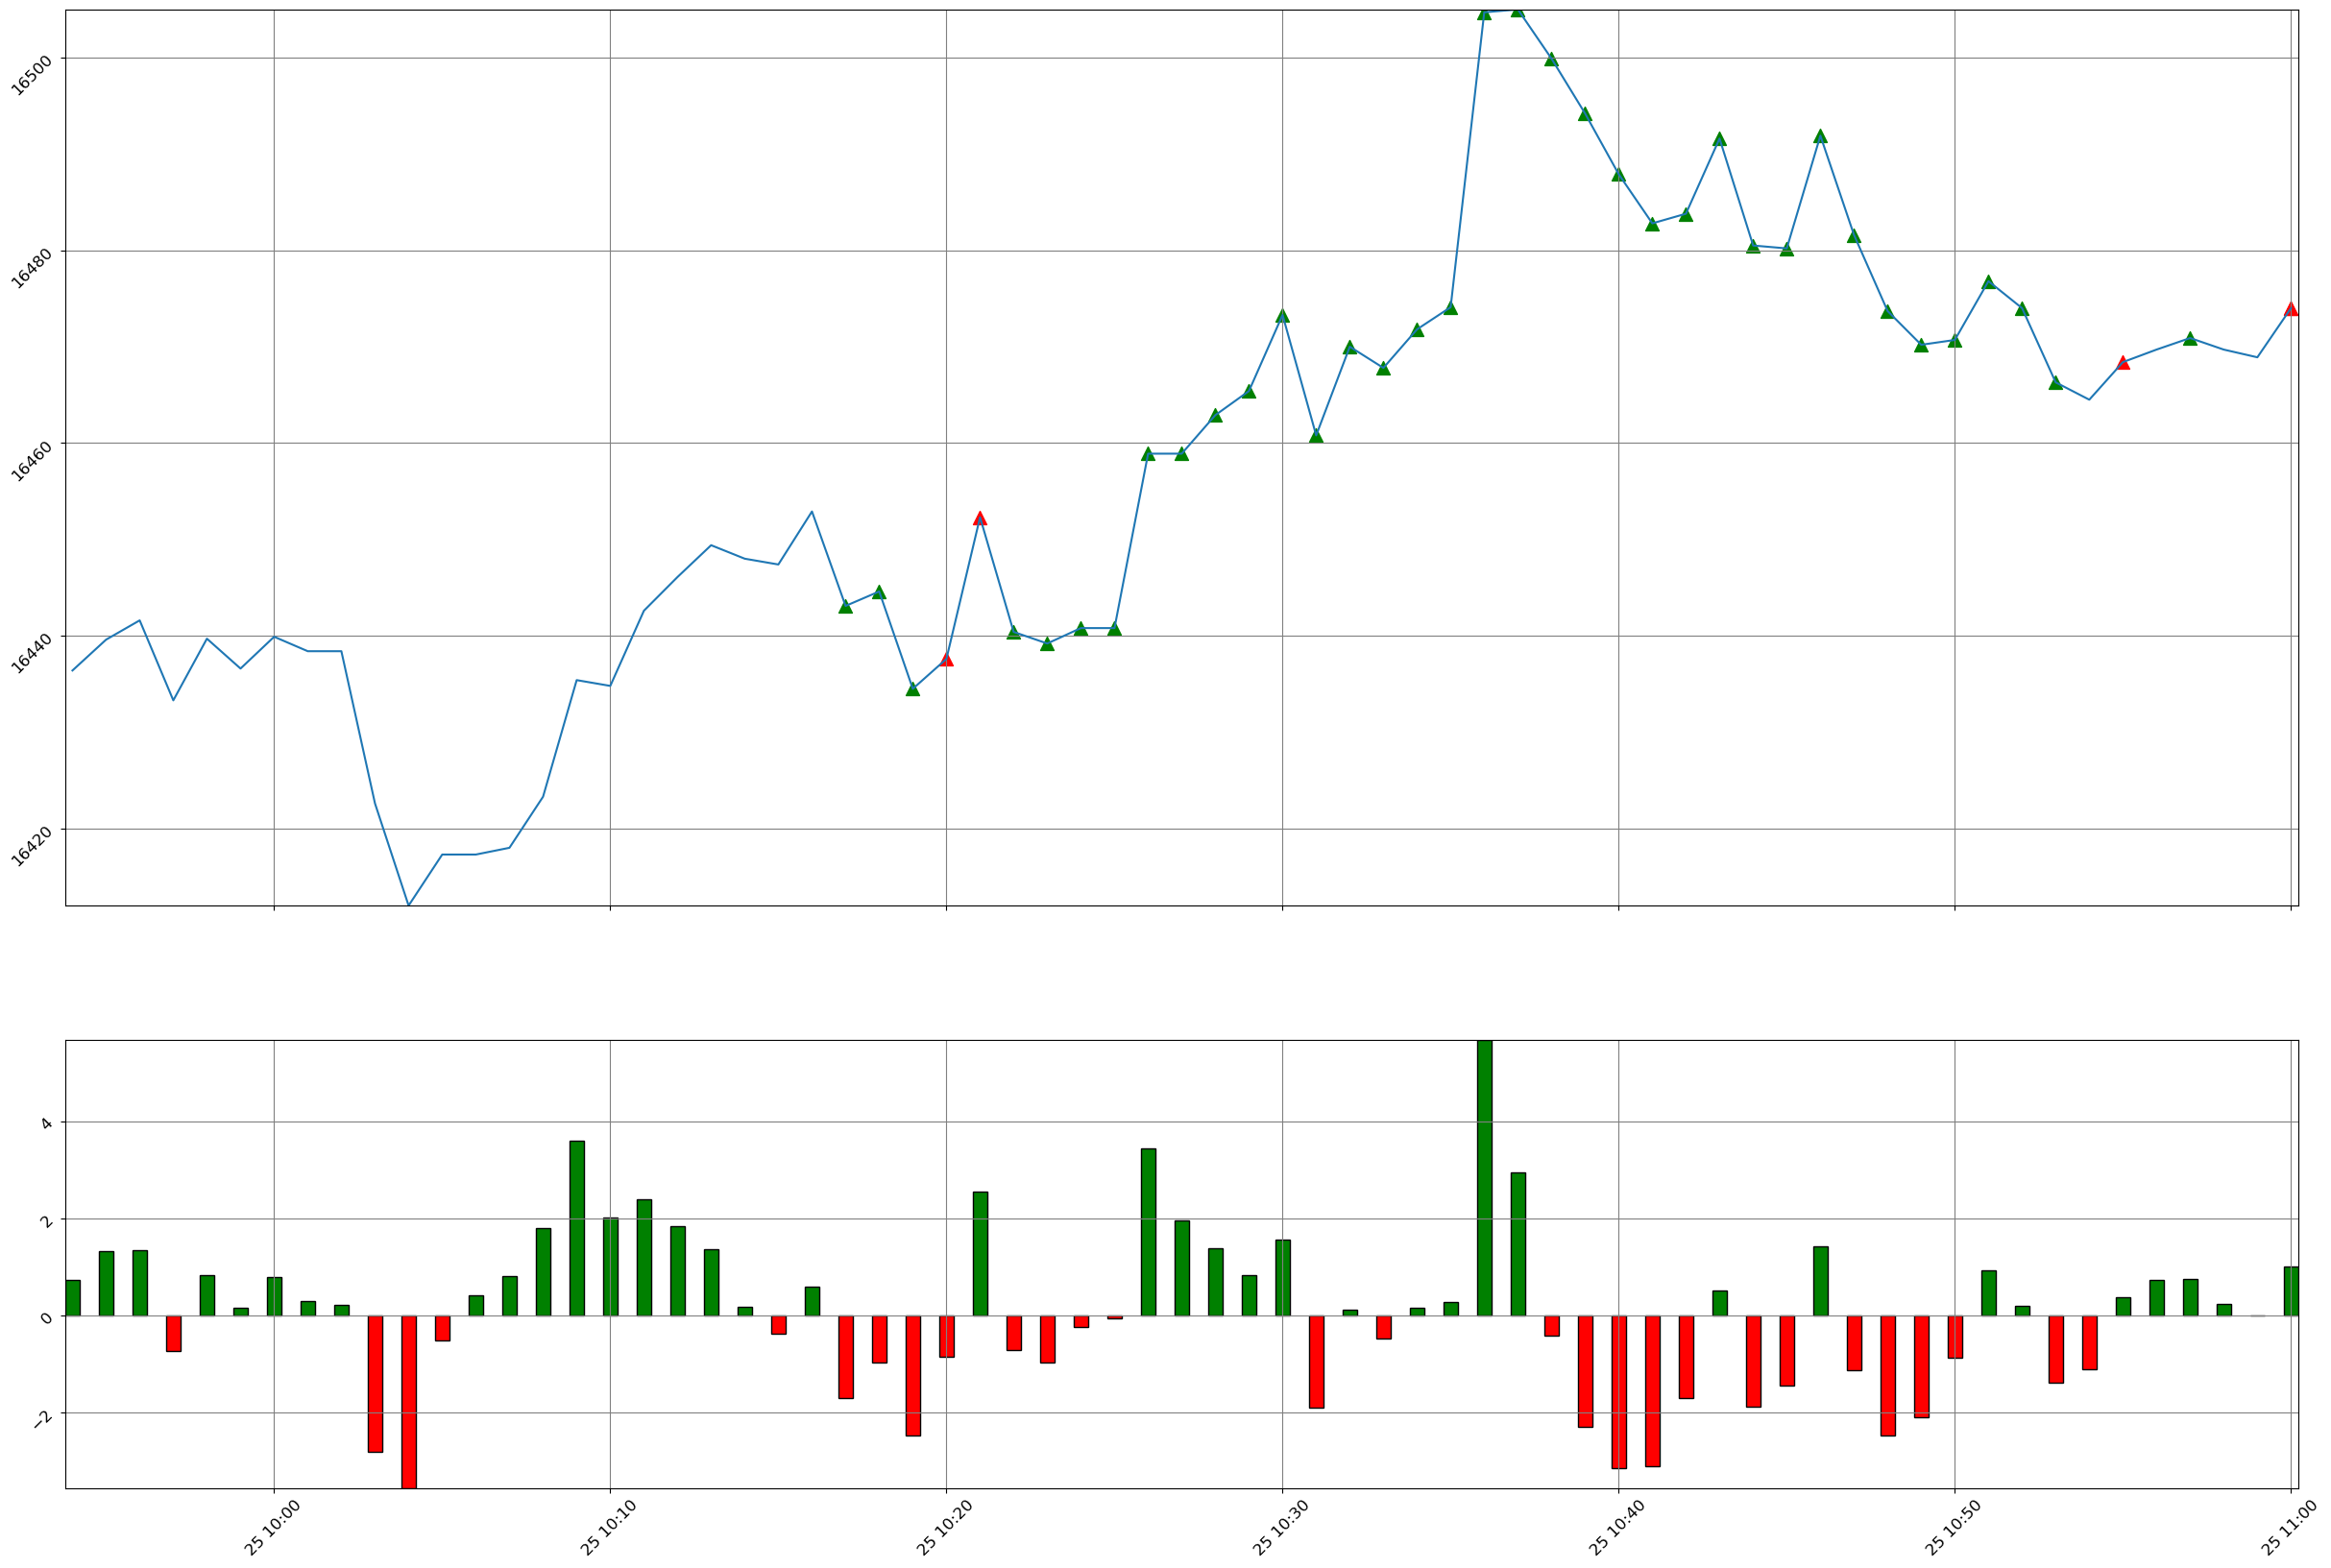

In [17]:
test_trader.plot_results(width_bars=0.0003)